In [ ]:
#导入模块
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

train_housing = pd.read_csv("train.csv", encoding = "UTF-8")
test_housing = pd.read_csv("test.csv", encoding = "UTF-8")

#处理建成年代
current_year = datetime.now().year 

#去除掉缺失值为0的值
train_housing = train_housing[train_housing['buildTime'] != 0]
test_housing = test_housing[test_housing['buildTime'] != 0]
print(train_housing.head(5))
print(test_housing.head(5))

def do_2(train_housing):
    import math
    # 成都市中心的经纬度（北纬, 东经）  
    center_lon, center_lat = 104.06, 30.67  
      
    # 转换经纬度到弧度  
    def deg2rad(deg):  
        return deg * (math.pi/180)  
      
    # 哈弗赛恩公式计算距离  
    def haversine_distance(lat1, lon1, lat2, lon2):  
        # 将角度转换为弧度  
        lat1, lon1, lat2, lon2 = map(deg2rad, [lat1, lon1, lat2, lon2])  
      
        # 哈弗赛恩公式  
        dlon = lon2 - lon1   
        dlat = lat2 - lat1   
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2  
        c = 2 * math.asin(math.sqrt(a))   
        r = 6371  # 地球半径，单位：千米  
        return c * r  
      
    # 遍历数据框，计算每套房子的距离并添加到新列  
    train_housing['distance_to_center'] = train_housing.apply(lambda row: haversine_distance(row['latitude'], row['longitude'], center_lat, center_lon), axis=1)  
    
    return test_housing

train_housing = do_2(train_housing)
test_housing = do_2(test_housing)

def do(train_housing):
    # 处理朝向 
    orientation_column_name = 'orientation'  # 假设这是列名  
      
    # 将朝向列转换为字符串 
    if train_housing[orientation_column_name].dtype != 'object':   
        train_housing[orientation_column_name] = train_housing[orientation_column_name].astype(str)  
      
    # 使用条件筛选去除非整数样本（只包含数字的字符串）  
    train_housing = train_housing[train_housing[orientation_column_name].apply(lambda x: x.isdigit())]  
    test_housing = train_housing[train_housing[orientation_column_name].apply(lambda x: x.isdigit())]    
    print(train_housing)
    return train_housing
train_housing = do(train_housing)
test_housing = do(test_housing)

#添加截距项
train_housing['cons'] = 1
test_housing['cons'] = 1
train_housing.head()

#清洗缺失值
train_housing = train_housing.dropna()
test_housing = test_housing.dropna()
train_housing

train_housing["orientation"] = train_housing["orientation"].astype(int)
test_housing["orientation"] = test_housing["orientation"].astype(int)

#显示行项
print(train_housing.columns)

#单变量数据关联趋势的图形化观察
plt.scatter(train_housing.distance_to_center, train_housing.unitPrice)
plt.scatter(train_housing.longitude, train_housing.unitPrice)
plt.scatter(train_housing.latitude, train_housing.unitPrice)
plt.scatter(train_housing.orientation, train_housing.unitPrice)

#多变量关联性分析
from statsmodels.regression.linear_model import OLS
regress = OLS(train_housing.unitPrice, train_housing[["cons", 'houseSpace', 'fitment', 'houseFloor', 'houseStructure', 'isNearSubway', 'longitude', 'latitude', 'buildTime', 'orientation']], missing = "drop").fit()
regress.summary()

# 划分数据集为训练集和测试集  
X_train = train_housing[['cons', 'houseSpace', 'fitment', 'houseFloor', 'houseStructure', 'isNearSubway', 'buildTime', 'distance_to_center', 'orientation']]  
y_train = train_housing["unitPrice"]  
X_test = test_housing[['cons', 'houseSpace', 'fitment', 'houseFloor', 'houseStructure', 'isNearSubway', 'buildTime', 'distance_to_center', 'orientation']] 
y_test = test_housing["unitPrice"] 

# 使用 statsmodels 训练 OLS 模型  
from statsmodels.regression.linear_model import OLS 
import statsmodels.api as sm  

model = sm.OLS(y_train, X_train).fit()  
print(model.summary())

# 模型诊断  
# 残差图  
plt.scatter(model.predict(), model.resid)  
plt.xlabel('Pred valuesicted')  
plt.ylabel('Residuals')  
plt.title('Residuals vs Fitted')  
plt.show() 

#正态性检验
from scipy import stats  
  
jb_value, p_value = stats.jarque_bera(model.resid)  
skew_value = stats.skew(model.resid)  
kurtosis_value = stats.kurtosis(model.resid, fisher=False)  # fisher=False 返回与 Jarque-Bera 相同的定义  
  
print('Jarque-Bera statistic:', jb_value)  
print('p-value:', p_value)  
print('Skew:', skew_value)  
print('Kurtosis:', kurtosis_value)

#检查异常值（使用IQR方法）  
def detect_outliers_iqr(series, threshold=1.5):  
    Q1 = series.quantile(0.25)  
    Q3 = series.quantile(0.75)  
    IQR = Q3 - Q1  
    return (series < (Q1 - threshold * IQR)) | (series > (Q3 + threshold * IQR))  
  
residuals = model.resid  
outliers = detect_outliers_iqr(residuals)  
print(f"Outliers in residuals: {outliers.sum()}")  
  
df_clean = train_housing.loc[~outliers]

from statsmodels.formula.api import ols  
# 重新拟合模型
model_clean = ols('unitPrice ~ cons + houseSpace + fitment + houseFloor + houseStructure + isNearSubway + distance_to_center + buildTime + orientation', data=df_clean).fit()  
print(model_clean.summary())

#R方
from sklearn.metrics import mean_squared_error  

# 使用模型进行预测  
y_pred = model_clean.predict(X_test)  

# 计算MSE  
mse = mean_squared_error(y_test, y_pred)  
  
# 计算RMSE  
rmse = np.sqrt(mse)  
  
print(f"MSE: {mse}")  
print(f"RMSE: {rmse}")


In [81]:
#导入模块
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

In [82]:
train_housing = pd.read_csv("train.csv", encoding = "UTF-8")
test_housing = pd.read_csv("test.csv", encoding = "UTF-8")

C:\Users\35892\AppData\Local\Temp\ipykernel_30148\2499667999.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  train_housing = pd.read_csv("train.csv", encoding = "UTF-8")


In [83]:
#处理建成年代
current_year = datetime.now().year  

In [84]:
#去除掉缺失值为0的值
train_housing = train_housing[train_housing['buildTime'] != 0]
test_housing = test_housing[test_housing['buildTime'] != 0]
print(train_housing.head(5))
print(test_housing.head(5))

   Unnamed: 0.1  Unnamed: 0              title              locateName  \
0            23          23       明星花苑 1室1厅 东南        ['明星花苑 ', '阳光城']   
1          1100        1100        锦绣尚城 3室1厅 西         ['锦绣尚城 ', '彭州']   
2          2222        2222      水务局家属区 3室1厅 南       ['水务局家属区 ', '五津']   
3          1053        1053  华熙528艺术村悦都 3室2厅 南  ['华熙528艺术村悦都 ', '三圣乡']   
4          1730        1730         雍景苑 3室1厅 北          ['雍景苑 ', '五津']   

  totalPrice  unitPrice                                          houseInfo  \
0       28.0       5681          1室1厅 | 49.29平米 | 东南 | 简装 | 中楼层(共6层)  | 板楼   
1       64.5       6272       3室1厅 | 102.84平米 | 西 | 其他 | 高楼层(共27层)  | 板塔结合   
2       64.0       5049        3室1厅 | 126.77平米 | 南 | 其他 | 高楼层(共6层)  | 暂无数据   
3      251.0      28298  3室2厅 | 88.7平米 | 南 | 其他 | 高楼层(共29层) | 2018年 | 板塔结合   
4       62.0       6368          3室1厅 | 97.37平米 | 北 | 毛坯 | 低楼层(共18层)  | 板楼   

         followInfo                               tags  \
0  18人关注 / 11个月以前发布         

In [85]:
def do_2(train_housing):
    import math
    # 成都市中心的经纬度（北纬, 东经）  
    center_lon, center_lat = 104.06, 30.67  
      
    # 转换经纬度到弧度  
    def deg2rad(deg):  
        return deg * (math.pi/180)  
      
    # 哈弗赛恩公式计算距离  
    def haversine_distance(lat1, lon1, lat2, lon2):  
        # 将角度转换为弧度  
        lat1, lon1, lat2, lon2 = map(deg2rad, [lat1, lon1, lat2, lon2])  
      
        # 哈弗赛恩公式  
        dlon = lon2 - lon1   
        dlat = lat2 - lat1   
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2  
        c = 2 * math.asin(math.sqrt(a))   
        r = 6371  # 地球半径，单位：千米  
        return c * r  
      
    # 遍历数据框，计算每套房子的距离并添加到新列  
    train_housing['distance_to_center'] = train_housing.apply(lambda row: haversine_distance(row['latitude'], row['longitude'], center_lat, center_lon), axis=1)  
    
    return test_housing

train_housing = do_2(train_housing)
test_housing = do_2(test_housing)

In [86]:
def do(train_housing):
    # 处理朝向 
    orientation_column_name = 'orientation'  # 假设这是列名  
      
    # 将朝向列转换为字符串 
    if train_housing[orientation_column_name].dtype != 'object':   
        train_housing[orientation_column_name] = train_housing[orientation_column_name].astype(str)  
      
    # 使用条件筛选去除非整数样本（只包含数字的字符串）  
    train_housing = train_housing[train_housing[orientation_column_name].apply(lambda x: x.isdigit())]  
    test_housing = train_housing[train_housing[orientation_column_name].apply(lambda x: x.isdigit())]    
    print(train_housing)
    return train_housing
train_housing = do(train_housing)
test_housing = do(test_housing)

      Unnamed: 0.1  Unnamed: 0            title             locateName  \
0             2259        2259       香满庭 3室2厅 南         ['香满庭 ', '毗河']   
1             1486        1486    远大中央公园 3室1厅 北      ['远大中央公园 ', '南湖']   
2             1559        1559    融创南湖逸家 3室2厅 西      ['融创南湖逸家 ', '华府']   
3             1234        1234  合能枫丹铂麓二期 3室2厅 南    ['合能枫丹铂麓二期 ', '麓山']   
4             2819        2819   碧桂园海昌天澜 4室2厅 南    ['碧桂园海昌天澜 ', '雅居乐']   
...            ...         ...              ...                    ...   
4914          2302        2302     半岛云著 3室2厅 东南        ['半岛云著 ', '大丰']   
4916             0           0    世茂城二期 4室2厅 东南       ['世茂城二期 ', '大面']   
4917          1430        1430    大陆美地西庭 4室1厅 南      ['大陆美地西庭 ', '犀浦']   
4918          2759        2759   川网国际花园 3室2厅 西北     ['川网国际花园 ', '蛟龙港']   
4919          1325        1325  金穗苑(温江) 4室2厅 东南  ['金穗苑(温江) ', '温江大学城']   

     totalPrice  unitPrice                                          houseInfo  \
0         158.0      13541  3室

In [87]:
print(train_housing.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'title', 'locateName', 'totalPrice',
       'unitPrice', 'houseInfo', 'followInfo', 'tags', 'url', 'locateName_0',
       'locateName_1', 'houseSpace', 'orientation', 'e', 'ne', 'n', 'nw', 'w',
       'sw', 's', 'se', 'fitment', '毛胚', '简装', '精装', 'houseFloor', '低', '中',
       '高', 'houseStructure', '塔楼', '板楼', '板塔结合', 'buildTime', 'isNearSubway',
       'longitude', 'latitude', 'distance_to_center'],
      dtype='object')


In [88]:
train_housing['cons'] = 1
test_housing['cons'] = 1
train_housing.head()

,Unnamed: 0.1,Unnamed: 0,title,locateName,totalPrice,unitPrice,houseInfo,followInfo,tags,url,...,houseStructure,塔楼,板楼,板塔结合,buildTime,isNearSubway,longitude,latitude,distance_to_center,cons
0,2259,2259,香满庭 3室2厅 南,"['香满庭 ', '毗河']",158.0,13541,3室2厅 | 116.69平米 | 南 | 其他 | 低楼层(共30层) | 2020年 | 板楼,1人关注 / 2个月以前发布,"['近地铁', 'VR看装修', '房本满两年']",https://cd.lianjia.com/ershoufang/106117381406...,...,2,0,1,0,2020.0,1,104.161491,30.805802,17.947484,1
1,1486,1486,远大中央公园 3室1厅 北,"['远大中央公园 ', '南湖']",240.0,24912,3室1厅 | 96.34平米 | 北 | 精装 | 中楼层(共33层) | 板塔结合,32人关注 / 一年前发布,"['VR看装修', '房本满两年', '随时看房']",https://cd.lianjia.com/ershoufang/106113934519...,...,3,0,0,1,NaN,0,104.049202,30.490709,19.963030,1
2,1559,1559,融创南湖逸家 3室2厅 西,"['融创南湖逸家 ', '华府']",168.0,25420,3室2厅 | 66.09平米 | 西 | 其他 | 低楼层(共33层) | 板塔结合,0人关注 / 1个月以前发布,"['近地铁', 'VR看装修', '房本满两年']",https://cd.lianjia.com/ershoufang/106117725665...,...,3,0,0,1,NaN,1,104.024761,30.490506,20.241900,1
3,1234,1234,合能枫丹铂麓二期 3室2厅 南,"['合能枫丹铂麓二期 ', '麓山']",330.0,23520,3室2厅 | 140.31平米 | 南 | 精装 | 高楼层(共10层) | 2020年 | 板楼,9人关注 / 一年前发布,"['近地铁', 'VR看装修', '房本满两年']",https://cd.lianjia.com/ershoufang/106111897847...,...,2,0,1,0,2020.0,1,104.103400,30.472489,22.351814,1
4,2819,2819,碧桂园海昌天澜 4室2厅 南,"['碧桂园海昌天澜 ', '雅居乐']",360.0,20082,4室2厅 | 179.27平米 | 南 | 毛坯 | 低楼层(共6层) | 板楼,1人关注 / 一年前发布,"['VR房源', '房本满五年', '随时看房']",https://cd.lianjia.com/ershoufang/106113909047...,...,2,0,1,0,NaN,0,104.133687,30.477561,22.531103,1


In [89]:
train_housing = train_housing.dropna()
test_housing = test_housing.dropna()
train_housing

,Unnamed: 0.1,Unnamed: 0,title,locateName,totalPrice,unitPrice,houseInfo,followInfo,tags,url,...,houseStructure,塔楼,板楼,板塔结合,buildTime,isNearSubway,longitude,latitude,distance_to_center,cons
0,2259,2259,香满庭 3室2厅 南,"['香满庭 ', '毗河']",158.0,13541,3室2厅 | 116.69平米 | 南 | 其他 | 低楼层(共30层) | 2020年 | 板楼,1人关注 / 2个月以前发布,"['近地铁', 'VR看装修', '房本满两年']",https://cd.lianjia.com/ershoufang/106117381406...,...,2,0,1,0,2020.0,1,104.161491,30.805802,17.947484,1
3,1234,1234,合能枫丹铂麓二期 3室2厅 南,"['合能枫丹铂麓二期 ', '麓山']",330.0,23520,3室2厅 | 140.31平米 | 南 | 精装 | 高楼层(共10层) | 2020年 | 板楼,9人关注 / 一年前发布,"['近地铁', 'VR看装修', '房本满两年']",https://cd.lianjia.com/ershoufang/106111897847...,...,2,0,1,0,2020.0,1,104.103400,30.472489,22.351814,1
8,1857,1857,恒大未来城一期 3室1厅 东南,"['恒大未来城一期 ', '光华大道沿线']",148.0,15850,3室1厅 | 93.38平米 | 东南 | 其他 | 高楼层(共28层) | 2019年 | 塔楼,0人关注 / 4个月以前发布,"['VR看装修', '房本满两年']",https://cd.lianjia.com/ershoufang/106116638956...,...,1,1,0,0,2019.0,0,103.863582,30.671961,18.786671,1
17,1023,1023,金山郡 4室2厅 东南,"['金山郡 ', '金堂']",99.0,7070,4室2厅 | 140.03平米 | 东南 | 精装 | 中楼层(共24层) | 2021年 ...,0人关注 / 一年前发布,"['VR看装修', '随时看房']",https://cd.lianjia.com/ershoufang/106113950811...,...,1,1,0,0,2021.0,0,104.408499,30.868768,39.964322,1
19,452,452,恒大银海湖 3室2厅 南,"['恒大银海湖 ', '崇州']",80.0,7173,3室2厅 | 111.53平米 | 南 | 精装 | 高楼层(共32层) | 2020年 | 板楼,0人关注 / 13天以前发布,"['VR房源', '房本满两年', '随时看房']",https://cd.lianjia.com/ershoufang/106118224269...,...,2,0,1,0,2020.0,0,103.757107,30.635502,29.226956,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4896,1987,1987,凤凰湖国际社区 1室1厅 西北,"['凤凰湖国际社区 ', '青白江']",30.0,6068,1室1厅 | 49.44平米 | 西北 | 毛坯 | 高楼层(共32层) | 2020年 |...,0人关注 / 5个月以前发布,随时看房,https://cd.lianjia.com/ershoufang/106116465521...,...,3,0,0,1,2020.0,0,104.285688,30.884090,32.118378,1
4901,2916,2916,杰座 1室1厅 东南,"['杰座 ', '丽都']",82.0,13864,1室1厅 | 59.15平米 | 东南 | 其他 | 中楼层(共16层) | 2009年 |...,0人关注 / 1个月以前发布,"['VR房源', '房本满两年']",https://cd.lianjia.com/ershoufang/106117608899...,...,3,0,0,1,2009.0,0,104.031866,30.624297,5.750631,1
4906,1652,1652,宏信南樾 3室2厅 西南,"['宏信南樾 ', '海洋公园']",160.0,14627,3室2厅 | 109.39平米 | 西南 | 精装 | 高楼层(共26层) | 2020年 ...,9人关注 / 4个月以前发布,"['VR房源', '房本满两年', '随时看房']",https://cd.lianjia.com/ershoufang/106116893710...,...,1,1,0,0,2020.0,0,104.073357,30.488513,20.220903,1
4914,2302,2302,半岛云著 3室2厅 东南,"['半岛云著 ', '大丰']",124.0,10946,3室2厅 | 113.29平米 | 东南 | 毛坯 | 低楼层(共6层) | 2019年 | 板楼,0人关注 / 1个月以前发布,"['VR看装修', '房本满两年', '随时看房']",https://cd.lianjia.com/ershoufang/106117655652...,...,2,0,1,0,2019.0,0,104.021071,30.821833,17.288092,1


In [90]:
train_housing["orientation"] = train_housing["orientation"].astype(int)
test_housing["orientation"] = test_housing["orientation"].astype(int)

In [91]:
print(train_housing.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'title', 'locateName', 'totalPrice',
       'unitPrice', 'houseInfo', 'followInfo', 'tags', 'url', 'locateName_0',
       'locateName_1', 'houseSpace', 'orientation', 'e', 'ne', 'n', 'nw', 'w',
       'sw', 's', 'se', 'fitment', '毛胚', '简装', '精装', 'houseFloor', '低', '中',
       '高', 'houseStructure', '塔楼', '板楼', '板塔结合', 'buildTime', 'isNearSubway',
       'longitude', 'latitude', 'distance_to_center', 'cons'],
      dtype='object')


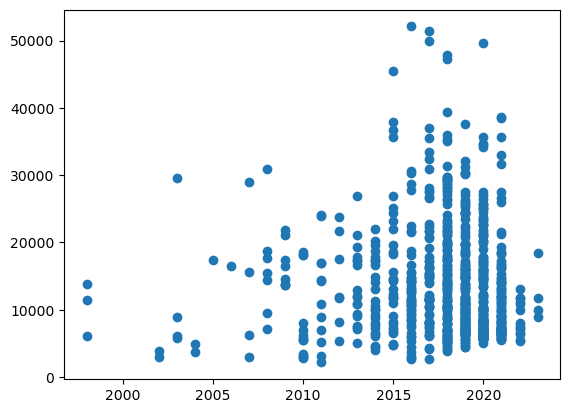

In [117]:
#数据关联趋势的图形化观察
plt.scatter(train_housing.buildTime, train_housing.unitPrice)

In [93]:
from statsmodels.regression.linear_model import OLS
regress = OLS(train_housing.unitPrice, train_housing[["cons", 'distance_to_center']], missing = "drop").fit()
regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              unitPrice   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     279.3
Date:                Tue, 14 May 2024   Prob (F-statistic):           5.86e-54
Time:                        08:42:05   Log-Likelihood:                -8194.4
No. Observations:                 797   AIC:                         1.639e+04
Df Residuals:                     795   BIC:                         1.640e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
cons                 2.16e+04    530.563     40.702      0.000    2.06e+04    2.26e+04
distance_to_center  -328.0352     19.629    -16.712      0.000    -366.566    -289.505
==============================================================================
Omnibus:                      293.390   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1027.276
Skew:                           1.765   Prob(JB):                    8.51e-224
Kurtosis:                       7.298   Cond. No.                         57.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
#多变量关联性分析
from statsmodels.regression.linear_model import OLS
regress = OLS(train_housing.unitPrice, train_housing[["cons", 'houseSpace', 'fitment', 'houseFloor', 'houseStructure', 'isNearSubway', 'distance_to_center', 'buildTime', 'orientation']], missing = "drop").fit()
regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              unitPrice   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     61.22
Date:                Tue, 14 May 2024   Prob (F-statistic):           1.16e-77
Time:                        08:42:05   Log-Likelihood:                -8121.8
No. Observations:                 797   AIC:                         1.626e+04
Df Residuals:                     788   BIC:                         1.630e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
cons               -4.558e+05   1.38e+05     -3.314      0.001   -7.26e+05   -1.86e+05
houseSpace            53.1353      7.356      7.224      0.000      38.697      67.574
fitment             1014.7465    169.491      5.987      0.000     682.040    1347.453
houseFloor          -249.1319    265.608     -0.938      0.349    -770.515     272.251
houseStructure       315.4555    233.806      1.349      0.178    -143.500     774.411
isNearSubway        4278.0356    571.452      7.486      0.000    3156.288    5399.783
distance_to_center  -277.8774     20.003    -13.892      0.000    -317.142    -238.612
buildTime            232.0951     68.256      3.400      0.001      98.111     366.079
orientation          -63.1902    104.822     -0.603      0.547    -268.954     142.573
==============================================================================
Omnibus:                      254.998   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              753.581
Skew:                           1.587   Prob(JB):                    2.30e-164
Kurtosis:                       6.551   Cond. No.                     1.21e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [121]:
# 划分数据集为训练集和测试集  
X_train = train_housing[['cons', 'houseSpace', 'fitment', 'houseFloor', 'houseStructure', 'isNearSubway', 'buildTime', 'distance_to_center', 'orientation']]  
y_train = train_housing["unitPrice"]  
X_test = test_housing[['cons', 'houseSpace', 'fitment', 'houseFloor', 'houseStructure', 'isNearSubway', 'buildTime', 'distance_to_center', 'orientation']] 
y_test = test_housing["unitPrice"]

In [109]:
# 使用 statsmodels 训练 OLS 模型  
from statsmodels.regression.linear_model import OLS 
import statsmodels.api as sm  

model = sm.OLS(y_train, X_train).fit()  
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              unitPrice   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     61.22
Date:                Tue, 14 May 2024   Prob (F-statistic):           1.16e-77
Time:                        08:54:17   Log-Likelihood:                -8121.8
No. Observations:                 797   AIC:                         1.626e+04
Df Residuals:                     788   BIC:                         1.630e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
cons               -4.558e+05   1.38

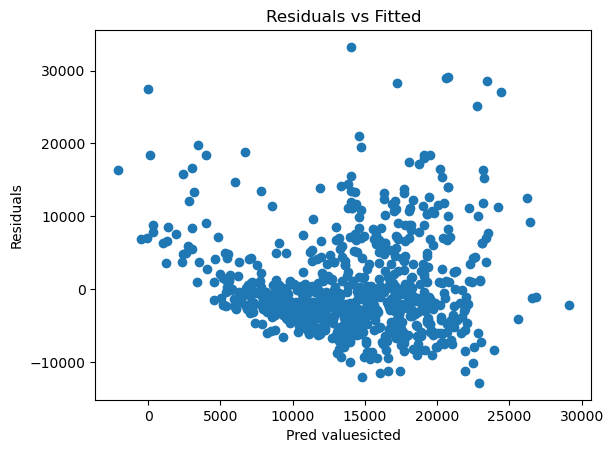

In [110]:
# 模型诊断  
# 残差图  
plt.scatter(model.predict(), model.resid)  
plt.xlabel('Pred valuesicted')  
plt.ylabel('Residuals')  
plt.title('Residuals vs Fitted')  
plt.show()  

In [111]:
#正态性检验
from scipy import stats  
  
jb_value, p_value = stats.jarque_bera(model.resid)  
skew_value = stats.skew(model.resid)  
kurtosis_value = stats.kurtosis(model.resid, fisher=False)  # fisher=False 返回与 Jarque-Bera 相同的定义  
  
print('Jarque-Bera statistic:', jb_value)  
print('p-value:', p_value)  
print('Skew:', skew_value)  
print('Kurtosis:', kurtosis_value)

Jarque-Bera statistic: 753.5807092163839
p-value: 2.301591045818341e-164
Skew: 1.587473615802005
Kurtosis: 6.551369918263354


In [113]:
#检查异常值（使用IQR方法）  
def detect_outliers_iqr(series, threshold=1.5):  
    Q1 = series.quantile(0.25)  
    Q3 = series.quantile(0.75)  
    IQR = Q3 - Q1  
    return (series < (Q1 - threshold * IQR)) | (series > (Q3 + threshold * IQR))  
  
# 假设我们检查残差中的异常值  
residuals = model.resid  
outliers = detect_outliers_iqr(residuals)  
print(f"Outliers in residuals: {outliers.sum()}")  
  
# 如果需要，可以基于outliers删除这些观测值  
df_clean = train_housing.loc[~outliers]

Outliers in residuals: 58


In [115]:
from statsmodels.formula.api import ols  
# 重新拟合模型
model_clean = ols('unitPrice ~ cons + houseSpace + fitment + houseFloor + houseStructure + isNearSubway + distance_to_center + buildTime + orientation', data=df_clean).fit()  
print(model_clean.summary())

                            OLS Regression Results                            
Dep. Variable:              unitPrice   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     99.96
Date:                Tue, 14 May 2024   Prob (F-statistic):          6.43e-112
Time:                        09:00:55   Log-Likelihood:                -7239.4
No. Observations:                 739   AIC:                         1.450e+04
Df Residuals:                     730   BIC:                         1.454e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -2.269e+05   4.75

45.4 ms ± 2.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

In [123]:
#R方
from sklearn.metrics import mean_squared_error  

# 使用模型进行预测  
y_pred = model_clean.predict(X_test)  
  


In [124]:
# 计算MSE  
mse = mean_squared_error(y_test, y_pred)  
  
# 计算RMSE  
rmse = np.sqrt(mse)  
  
print(f"MSE: {mse}")  
print(f"RMSE: {rmse}")

MSE: 44126949.34038946
RMSE: 6642.811854959424
